# Forêts aléatoire d'arbres de décision

Dans cette feuille nous allons:
    1. Etudier l'influence d'une augmentation de la taille de la base de données (10000-->20000 points)
    2. analyser la pertinence des données d'entrée pour l'obtention d'un modèle de type Random Forest du terme de sous-maille sur la pression.
    
Les analyses présentes dans cette feuille sont très inspirées de la suite d'articles en lignes ci-dessous (à lire dans l'ordre)
- https://medium.com/@williamkoehrsen/random-forest-simple-explanation-377895a60d2d
- https://towardsdatascience.com/random-forest-in-python-24d0893d51c0
- https://towardsdatascience.com/improving-random-forest-in-python-part-1-893916666cd
- https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

### Chargement des paquets python essentiels

In [1]:
# Random Forest Regression
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import sys
import datetime, os
from sklearn import preprocessing

In [2]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


### Fonction d'évaluation des modèles

In [3]:
def evaluate(model, test_features, test_labels):
    from sklearn import metrics
    predictions = model.predict(test_features)
    #R2
    R2=metrics.r2_score(test_labels, predictions)
    #Correlation entre predictions et vraies donnees
    Correl=np.corrcoef(test_labels, predictions)[0, 1]
    print('Model Performance:')
    print('Correlation: {:0.4f}.'.format(Correl))
    print('R2: {:0.4f}.'.format(R2))

### Fonction de visualisation des modèles

In [4]:
# Visualising the Random Forest Regression results 
def visualize(model, test_features, test_labels):
    X_test=test_labels
    Y_pred=model.predict(test_features)
    Y_test=test_labels
    plt.scatter(Y_test,Y_pred, color = 'red',marker=".")
    plt.scatter(Y_test,Y_test, color = 'black',marker=".")
    plt.title('Random Forest Regression Results')
    plt.xlabel('sgs_exact')
    plt.ylabel('sgs_model')
    plt.show()

### Chargement des données et normalisation

A noter qu'ici pour réduire le temps de calcul, toutes les données ne sont pas chargées. Il ne s'agit donc ici "que" d'illustrer l'approche. Le même travail doit en réalité être réalisé à l'aide d'une implémentation réellement parallèle de ces méthodes et sur un cluster de calcul (les temps de calcul ci-dessous parlent pour eux-même)

In [5]:
# Importing the datasets

column_names = ['sgs_p','rho','tempe','press','rhoe',
                'gradrho', 'gradt', 'gradp','gradroe','laprho','laprhoe','inv1','inv2','inv3']
raw_dataset = pd.read_csv('data.dat', names=column_names,
                      sep=" ",nrows = 10000)#, skipinitialspace=True)

data = raw_dataset.copy()
x = data.values #returns a numpy array
x_scaled = preprocessing.scale(x)
data = pd.DataFrame(x_scaled)
data.columns = ['sgs_p','rho','tempe','press','rhoe',
                'gradrho', 'gradt', 'gradp','gradroe','laprho','laprhoe','inv1','inv2','inv3']


# CHeck if there are any NaN entries
data.isna().sum()
# Drop them if any
data = data.dropna()
#Print tail to check
data.tail()

,sgs_p,rho,tempe,press,rhoe,gradrho,gradt,gradp,gradroe,laprho,laprhoe,inv1,inv2,inv3
9995,0.097784,-0.716074,-0.942000,-0.748789,-0.717837,0.494740,1.081111,1.262590,0.497256,0.597887,0.863976,-1.020403,-0.973945,1.430293
9996,0.185565,-0.591395,-0.719340,-0.523976,-0.592961,0.661310,1.243676,1.340896,0.664708,0.165694,0.789254,0.796361,-1.130888,1.555410
9997,-0.043294,-0.419354,-0.419821,-0.243867,-0.420377,0.643234,1.043444,1.133994,0.646151,-0.890383,-1.094420,-0.960224,-1.059240,1.423937
9998,-0.380787,-0.235838,-0.156400,0.014386,-0.236615,0.535882,0.612443,0.780502,0.536276,-1.186591,-1.145398,0.807814,-0.840958,1.146090
9999,-0.662035,-0.063521,0.023107,0.218682,-0.064835,0.539126,0.303150,0.546398,0.536142,-1.262554,-1.158252,0.816970,-0.529252,0.741168


### Séparation entre données d'entraînement et de test

In [6]:
# One Hot Encoding
features = pd.get_dummies(data)

# Extract features and labels
labels = features['sgs_p']
features = features.drop('sgs_p', axis = 1)

# List of features for later use
feature_list = list(features.columns)

# Convert to numpy arrays
import numpy as np

features = np.array(features)
labels = np.array(labels)

# Training and Testing Sets
from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels = train_test_split(features, labels, 
                                                                            test_size = 0.25, random_state = 42)

In [7]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (7500, 13)
Training Labels Shape: (7500,)
Testing Features Shape: (2500, 13)
Testing Labels Shape: (2500,)


## Evaluation des qualités du modèle de base

### Examen des paramètres par défaut de la random forest

In [8]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state = 42, n_jobs = -1)

from pprint import pprint

# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


Model Performance:
Correlation: 0.8597.
R2: 0.7366.


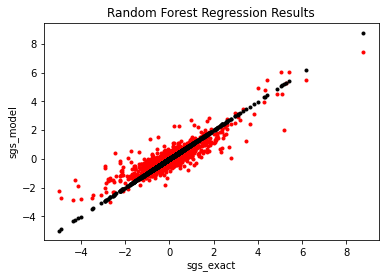

In [9]:
base_model = RandomForestRegressor(n_estimators = 1000, random_state = 42 , n_jobs = -1)
base_model.fit(train_features, train_labels)
evaluate(base_model, test_features, test_labels)
visualize(base_model, test_features, test_labels)

## Analyse de l'influence d'une extension de la base de données

On étudie ici l'influence d'une augmentation d'un facteur 2 du nombre d'échantillons disponibles

In [10]:
# Importing the datasets


column_names = ['sgs_p','rho','tempe','press','rhoe',
                'gradrho', 'gradt', 'gradp','gradroe','laprho','laprhoe','inv1','inv2','inv3']
raw_dataset_ext = pd.read_csv('data.dat', names=column_names, sep=" ",nrows = 20000)

data_ext = raw_dataset_ext.copy()
x = data_ext.values #returns a numpy array
x_scaled = preprocessing.scale(x)
data_ext = pd.DataFrame(x_scaled)
data_ext.columns = ['sgs_p','rho','tempe','press','rhoe',
                'gradrho', 'gradt', 'gradp','gradroe','laprho','laprhoe','inv1','inv2','inv3']


# CHeck if there are any NaN entries
data_ext.isna().sum()
# Drop them if any
data_ext = data_ext.dropna()
#Print tail to check
data_ext.tail()


,sgs_p,rho,tempe,press,rhoe,gradrho,gradt,gradp,gradroe,laprho,laprhoe,inv1,inv2,inv3
19995,0.133481,-0.757384,-0.729132,-0.803793,-0.759231,-1.148668,-2.641110,-0.739746,-1.162829,0.689648,0.892907,0.972692,1.711237,0.743157
19996,0.477342,-0.739996,-0.718058,-0.770640,-0.741953,-1.139041,-2.462876,-0.748466,-1.150326,0.825850,0.917272,0.941822,1.491062,0.508390
19997,0.611319,-0.686858,-0.656958,-0.669635,-0.688994,-1.117478,-1.459071,-0.748346,-1.122005,0.798690,0.912581,0.877860,1.014154,0.592557
19998,0.597454,-0.623715,-0.555835,-0.552089,-0.625771,-1.291204,-1.067280,-0.983220,-1.287225,0.702745,0.895559,-0.938795,0.639900,0.600852
19999,0.466121,-0.573069,-0.443671,-0.458389,-0.574646,-1.357729,-0.946468,-1.111077,-1.349445,0.604242,0.877689,-0.990868,0.791245,0.250695


### Séparation entre données d'entraînement et de test

In [11]:
# One Hot Encoding
features_ext = pd.get_dummies(data_ext)

# Extract features and labels
labels_ext = features_ext['sgs_p']
features_ext = features_ext.drop('sgs_p', axis = 1)

# List of features for later use
feature_list_ext = list(features_ext.columns)

# Convert to numpy arrays
import numpy as np

features_ext = np.array(features_ext)
labels_ext = np.array(labels_ext)

# Training and Testing Sets
from sklearn.model_selection import train_test_split

train_features_ext, test_features_ext, train_labels_ext, test_labels_ext = train_test_split(features_ext, labels_ext, 
                                                                            test_size = 0.25, random_state = 42)

In [12]:
print('Training Features Shape:', train_features_ext.shape)
print('Training Labels Shape:', train_labels_ext.shape)
print('Testing Features Shape:', test_features_ext.shape)
print('Testing Labels Shape:', test_labels_ext.shape)

Training Features Shape: (15000, 13)
Training Labels Shape: (15000,)
Testing Features Shape: (5000, 13)
Testing Labels Shape: (5000,)


### Evaluation de la qualité du modèle pour la base de données étendue

Model Performance:
Correlation: 0.9022.
R2: 0.8061.


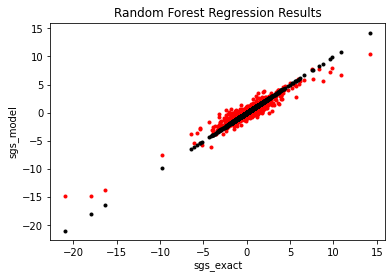

In [13]:
rf_ext = RandomForestRegressor(n_estimators = 1000, random_state = 42,n_jobs = -1)
rf_ext.fit(train_features_ext, train_labels_ext)
evaluate(rf_ext, test_features_ext, test_labels_ext)
visualize(rf_ext, test_features_ext, test_labels_ext)

## Analyse de la pertinence des paramètres d'entrée

In [14]:
# Get numerical feature importances
importances = list(rf_ext.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: tempe                Importance: 0.19
Variable: laprhoe              Importance: 0.16
Variable: rho                  Importance: 0.11
Variable: press                Importance: 0.1
Variable: rhoe                 Importance: 0.08
Variable: gradrho              Importance: 0.07
Variable: gradp                Importance: 0.06
Variable: gradroe              Importance: 0.06
Variable: laprho               Importance: 0.06
Variable: gradt                Importance: 0.03
Variable: inv1                 Importance: 0.03
Variable: inv2                 Importance: 0.03
Variable: inv3                 Importance: 0.03


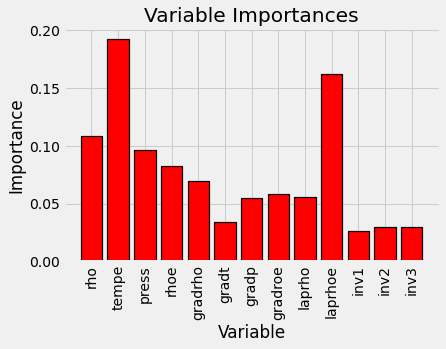

In [15]:
# Reset style 
plt.style.use('fivethirtyeight')

# list of x locations for plotting
x_values = list(range(len(importances)))

# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical', color = 'r', edgecolor = 'k', linewidth = 1.2)

# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')

# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

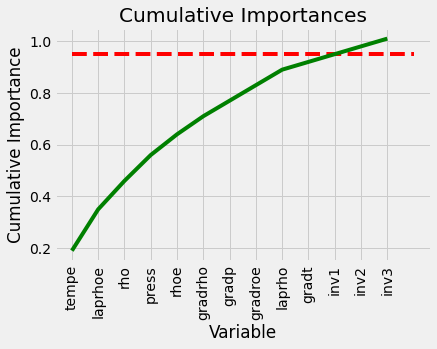

In [16]:
# List of features sorted from most to least important
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]

# Cumulative importances
cumulative_importances = np.cumsum(sorted_importances)

# Make a line graph
plt.plot(x_values, cumulative_importances, 'g-')

# Draw line at 95% of importance retained
plt.hlines(y = 0.95, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')

# Format x ticks and labels
plt.xticks(x_values, sorted_features, rotation = 'vertical')

# Axis labels and title
plt.xlabel('Variable'); plt.ylabel('Cumulative Importance'); plt.title('Cumulative Importances');

### Limitation du nombre de variables d'entrée

Nous allons maintenant réduire le nombre de variables utilisées par le modèle à celles qui sont nécessaires pour représenter 95 % de l’importance cumulative. 
Le même nombre de variables doit être utilisé dans les ensembles de formation et d’essai.

In [17]:
# Find number of features for cumulative importance of 95%
# Add 1 because Python is zero-indexed
print('Number of features for 95% importance:', np.where(cumulative_importances > 0.95)[0][0] + 1)
nbf=np.where(cumulative_importances > 0.95)[0][0] + 1
# Extract the names of the most important features
important_feature_names = [feature[0] for feature in feature_importances[0:nbf]]
# Find the columns of the most important features
important_indices = [feature_list.index(feature) for feature in important_feature_names]

# Create training and testing sets with only the important features
important_train_features = train_features_ext[:, important_indices]
important_test_features = test_features_ext[:, important_indices]

# Sanity check on operations
print('Important train features shape:', important_train_features.shape)
print('Important test features shape:', important_test_features.shape)

Number of features for 95% importance: 11
Important train features shape: (15000, 11)
Important test features shape: (5000, 11)


### Analyse des qualités d'un modèle limité aux variables importantes

Model Performance:
Correlation: 0.8946.
R2: 0.7944.


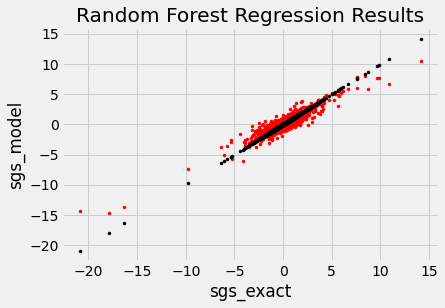

In [18]:
rf_imp = RandomForestRegressor(n_estimators = 1000, random_state = 42,n_jobs = -1)
rf_imp.fit(important_train_features, train_labels_ext)
evaluate(rf_imp, important_test_features, test_labels_ext)
visualize(rf_imp, important_test_features, test_labels_ext)